# Portfolio management (Markovitz)

In [27]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from timeit import default_timer as timer
sns.set(style="whitegrid")

## Dataset

In [28]:
stocks_data = glob.glob("Data/*.csv")

df = pd.DataFrame()

for stock in stocks_data:

    stock_name = stock.split("_")[0].split("\\")[1]
    
    data = pd.read_csv(stock, index_col="Data", parse_dates=True)
    data["Zmiana"] = ((data["Zamkniecie"]/data["Zamkniecie"].shift(+1))-1)
    data.dropna(inplace=True)
    data[stock_name] = data["Zmiana"]
    
    df = pd.merge(df, 
                  data[stock_name], 
                  how="outer", 
                  left_index=True, 
                  right_index=True)

df.tail()

,cmr,cog,mrc,neu,xtb
Data,,,,,
2020-09-21,-0.004854,-0.033898,-0.054124,-0.012897,-0.062857
2020-09-22,-0.019512,-0.008772,0.035422,-0.008040,0.018293
2020-09-23,0.009950,-0.026549,0.015789,-0.015198,-0.026946
2020-09-24,-0.014778,0.004545,0.064767,-0.005144,-0.036923
2020-09-25,-0.005000,0.085973,0.136253,0.003102,-0.041534


In [29]:
data.tail()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zmiana,xtb
Data,,,,,,,
2020-09-21,17.70,17.80,16.30,16.40,878495,-0.062857,-0.062857
2020-09-22,16.50,17.10,16.30,16.70,415494,0.018293,0.018293
2020-09-23,16.55,16.80,16.05,16.25,505487,-0.026946,-0.026946
2020-09-24,16.05,16.10,15.65,15.65,512977,-0.036923,-0.036923
2020-09-25,15.65,15.75,14.95,15.00,845561,-0.041534,-0.041534


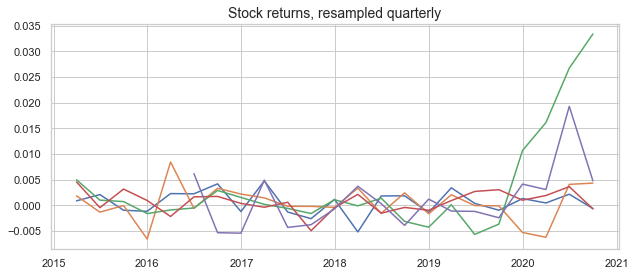

In [30]:
plt.figure(figsize=(9, 4))
plt.plot(df.resample("BQ").mean())
#plt.legend(df.columns)
plt.title("Stock returns, resampled quarterly", size=14)

plt.tight_layout()
plt.show()

## Key parameters

In [31]:
risk_free_return = 0.00
stock_return_average = df.apply("mean", axis=0)
stock_return_std = df.apply("std", axis=0)
stock_sharp_ratio = (stock_return_average
                     .apply(lambda x: x - risk_free_return))/stock_return_std

dict = {"Average stock returns": stock_return_average, 
        "Stock standard deviations": stock_return_std,
        "Stock Sharpes ratio": stock_sharp_ratio}

summary = pd.DataFrame(dict)
summary

,Average stock returns,Stock standard deviations,Stock Sharpes ratio
cmr,0.000576,0.019600,0.029379
cog,0.000396,0.031841,0.012448
mrc,0.003439,0.043966,0.078215
neu,0.000692,0.016925,0.040872
xtb,0.000932,0.037488,0.024859


## Covariance matrix

In [32]:
covMatrix = pd.DataFrame.cov(df)
covMatrix

,cmr,cog,mrc,neu,xtb
cmr,0.000384,0.000042,0.000058,0.000042,0.000005
cog,0.000042,0.001014,0.000076,0.000048,0.000129
mrc,0.000058,0.000076,0.001933,0.000088,0.000331
neu,0.000042,0.000048,0.000088,0.000286,0.000045
xtb,0.000005,0.000129,0.000331,0.000045,0.001405


## Simulations

In [33]:
np.random.seed(26)

sim = 50_000

# creating a portfolio scenarios
# simulations = rows, columns = stocks tikers, values = allocations
allocations = np.zeros((sim, len(df.columns)))

# arrays for storing the results of each portfolio scenario
returns = np.zeros(sim)
stdev = np.zeros(sim)
sharpe = np.zeros(sim)

for s in range(sim):

    # choosing a random pick size for each stock
    allocation = np.array(
        np.random.random(len(df.columns)))
    
    # each stock has its weight in the given portfolio
    allocation = allocation/np.sum(allocation)
    
    # assigning values to the allocations array, s= row, := following columns
    allocations[s, :] = allocation

    # calculating portfolio return
    returns[s] = np.sum(
        np.array(stock_return_average) * allocation * len(df))

    # calculating portfolio volitility
    stdev[s] = np.sqrt(
        np.dot(allocation.T, np.dot(covMatrix*len(df), allocation)))

    # calculating Sharpe's ratio for portfolio
    sharpe[s] = returns[s]/stdev[s]

## Results

In [34]:
portfolio = pd.Series(data=list(allocations[sharpe.argmax()]), 
                      index=list(df.columns), 
                      name="Optimal_"+str(sharpe.argmax()))

portfolio_r = pd.Series(data=list(allocations[returns.argmax()]), 
                        index=list(df.columns), 
                        name="Optimal_"+str(returns.argmax()))

portfolio_s = pd.Series(data=list(allocations[stdev.argmax()]),
                        index=list(df.columns), 
                        name="Optimal_"+str(stdev.argmax()))

optimal = portfolio.to_frame(name="Allocation (%):").round(2).T*100
max_ret = portfolio_r.to_frame(name="Allocation (%):").round(2).T*100
min_vol = portfolio_s.to_frame(name="Allocation (%):").round(2).T*100  

## Summary

In [35]:
def print_summary():
    
    print(f"\nNO OF SIMMULATIONS: {sim:,}\n")

    print("\nOPTIMAL PORTFOLIO")
    print("-"*50)    
    print(f"Sharpe max:          {sharpe.max().round(3)}") 
    print(f"Simulation no:       {sharpe.argmax()}")
    print(optimal)
    print("-"*50)
    
    print("\nMAX RETURN PORTFOLIO")
    print("-"*50)    
    print(f"Portfolio return:    {returns[sharpe.argmax()].round(3)}")
    print(f"Simulation no:       {returns.argmax()}")    
    print(max_ret)
    print("-"*50)
    
    print("\nMIN VOLITILITY PORTFOLIO")
    print("-"*50)
    print(f"Standard deviation:  {stdev[sharpe.argmax()].round(3)}")  
    print(f"Simulation no:       {stdev.argmax()}")     
    print(min_vol)
    print("-"*50, "\n")

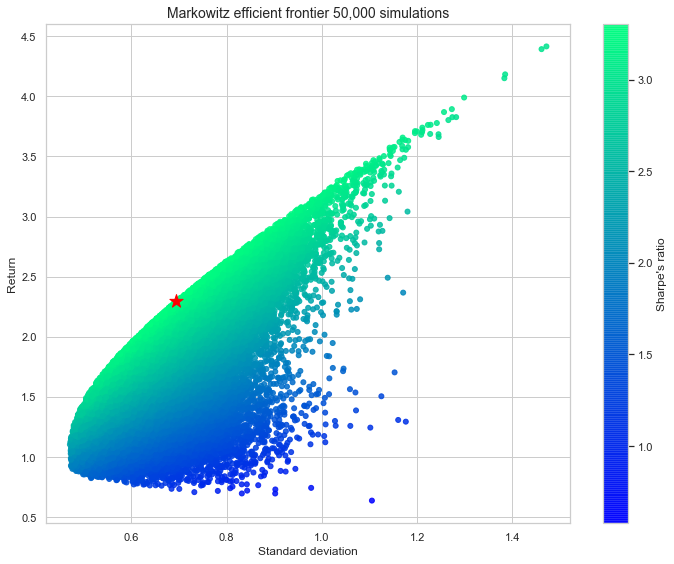

2.723744599999918 seconds


In [36]:
start = timer()

plt.figure(figsize=(10, 8))
plt.title(f"Markowitz efficient frontier {sim:,} simulations", size=14)
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.scatter(stdev, returns, c=sharpe, cmap="winter", alpha=0.85, s=25)
plt.colorbar(label="Sharpe's ratio")
plt.scatter(stdev[sharpe.argmax()], returns[sharpe.argmax()], c='red', s=195, marker="*")

plt.tight_layout()
plt.show()

end = timer()
print(end-start,"seconds")

In [37]:
print_summary()


NO OF SIMMULATIONS: 50,000


OPTIMAL PORTFOLIO
--------------------------------------------------
Sharpe max:          3.306
Simulation no:       18006
                  cmr  cog   mrc   neu  xtb
Allocation (%):  20.0  4.0  34.0  37.0  5.0
--------------------------------------------------

MAX RETURN PORTFOLIO
--------------------------------------------------
Portfolio return:    2.296
Simulation no:       8680
                 cmr  cog   mrc  neu  xtb
Allocation (%):  3.0  6.0  87.0  2.0  2.0
--------------------------------------------------

MIN VOLITILITY PORTFOLIO
--------------------------------------------------
Standard deviation:  0.695
Simulation no:       8680
                 cmr  cog   mrc  neu  xtb
Allocation (%):  3.0  6.0  87.0  2.0  2.0
-------------------------------------------------- 

